# Install Dependencies

In [20]:
%pip install langchain_openai==0.3.2 langgraph==0.2.68 langchain-community==0.3.16 langchain-experimental==0.3.4 langchain-core==0.3.32 ipython==8.31.0 pydantic-settings==2.7.1 httpx==0.28.1

Note: you may need to restart the kernel to use updated packages.


# Setup Environment

In [28]:
import os
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_postgres import PGVector

os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

CONNECTION = os.getenv('CONNECTION')
COLLECTION_NAME = os.getenv('COLLECTION_NAME')

llm = ChatOpenAI(model='gpt-4o-mini')
embeddings = OpenAIEmbeddings(model='text-embedding-3-small')

vector_store = PGVector(
    embeddings=embeddings,
    collection_name=COLLECTION_NAME,
    connection=CONNECTION,
    use_jsonb=True,
)

# Setup Schemas

In [29]:
import httpx
from typing import Optional

from pydantic import BaseModel, Field


class APIToolSchema(BaseModel):
    path: str = Field(default='', description='the api path')
    query_params: Optional[dict] = Field(
        default=None, description='Optional search parameters'
    )


class RAGToolSchema(BaseModel):
    question: str = Field(default='', description='question to perform similarity search in vector store')

# Setup Tools

In [30]:
from typing import Type
from langchain_core.prompts import ChatPromptTemplate
from langchain.tools import BaseTool
from langchain.callbacks.manager import (
    AsyncCallbackManagerForToolRun,
    CallbackManagerForToolRun,
)
from pydantic_settings import BaseSettings
from langchain_postgres import PGVector
from langchain import hub


class APITool(BaseTool, BaseSettings):
    name: str = 'api_tool'
    description: str = """Tool that calls GET on <https://mlb-player-api-924437296962.us-central1.run.app/players> apis and get uptodate information about players."""
    args_schema: Type[APIToolSchema] = APIToolSchema
    base_url: str = 'https://mlb-player-api-924437296962.us-central1.run.app/players'

    def _run(
            self,
            path: str = "",
            query_params: Optional[dict] = None,
            run_manager: Optional[CallbackManagerForToolRun] = None,
    ) -> dict:
        """Run the tool"""
        result = httpx.Client().get(self.base_url)

        print(result)
        return result.json()

    async def _arun(
            self,
            path: str = '',
            query_params: Optional[dict] = None,
            run_manager: Optional[AsyncCallbackManagerForToolRun] = None,
    ) -> dict:
        """Run the tool asynchronously."""

        async with httpx.AsyncClient() as client:
            result = await client.get(self.base_url)
            return result.json()


class RAGTool(BaseTool, BaseSettings):
    name: str = 'rag_tool'
    description: str = """Tool that gets the most similar documents from the vector database."""
    args_schema: Type[RAGToolSchema] = RAGToolSchema
    prompt: ChatPromptTemplate = hub.pull('rlm/rag-prompt')
    vector_store: PGVector | None = None

    def __init__(self, connection_string: str, collection_name: str):
        super().__init__()
        self.vector_store = PGVector(
            embeddings=embeddings,
            collection_name=collection_name,
            connection=connection_string,
            use_jsonb=True,
        )

    def _run(
            self,
            question: str,
            run_manager: Optional[CallbackManagerForToolRun] = None,
    ) -> dict:
        """Run the tool"""

        retrieved_docs = self.vector_store.similarity_search(question)
        docs_content = '\n\n'.join(doc.page_content for doc in retrieved_docs)
        messages = self.prompt.invoke({'question': question, 'context': docs_content})
        response = llm.invoke(messages)

        return response.content

    async def _arun(
            self,
            question: str,
            run_manager: Optional[AsyncCallbackManagerForToolRun] = None,
    ) -> dict:
        """Run the tool asynchronously."""

        retrieved_docs = self.vector_store.similarity_search(question)
        docs_content = '\n\n'.join(doc.page_content for doc in retrieved_docs)
        messages = self.prompt.invoke({'question': question, 'context': docs_content})
        response = llm.invoke(messages)

        return response.content


api_tool = APITool()
rag_tool = RAGTool(connection_string=CONNECTION, collection_name=COLLECTION_NAME)

# Testing Tools

In [31]:
rag_output = rag_tool.run({'question': 'ducks'})
api_output = api_tool.run({'path': ''})
print(api_output)
print('\n---\n')
print(rag_output)

<Response [200 OK]>
[{'id': 1, 'name': 'Juan Soto', 'age': 26, 'contract_start_date': '2024-12-11', 'contract_end_date': '2039-12-10', 'team': 'New York Mets', 'country': 'Dominican Republic', 'salary': '51 million per year'}, {'id': 2, 'name': 'Brent Rooker', 'age': 30, 'contract_start_date': '2025-01-07', 'contract_end_date': '2030-01-06', 'team': 'Oakland Athletics', 'country': 'United States', 'salary': '12 million per year'}, {'id': 3, 'name': 'Blake Snell', 'age': 32, 'contract_start_date': '2025-01-01', 'contract_end_date': '2029-12-31', 'team': 'Los Angeles Dodgers', 'country': 'United States', 'salary': '36.4 million per year'}, {'id': 4, 'name': 'Paul Goldschmidt', 'age': 37, 'contract_start_date': '2024-12-30', 'contract_end_date': '2025-12-29', 'team': 'New York Yankees', 'country': 'United States', 'salary': '12.5 million per year'}, {'id': 5, 'name': 'Reynaldo López', 'age': 31, 'contract_start_date': '2023-11-20', 'contract_end_date': '2026-11-19', 'team': 'Atlanta Brave

# Create Agents

In [37]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

members = ['sport_agent', 'place_agent']
options = members + ['FINISH']
system_prompt = (
    'You are a supervisor tasked with managing a conversation between the'
    f' following workers: {members}. Given the following user request,'
    ' respond with the worker to act next. Each worker will perform a'
    ' task and respond with their results and status. When finished,'
    ' respond with FINISH.'
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


class State(MessagesState):
    next: str


sport_agent = create_react_agent(
    llm, tools=[api_tool], prompt='You are a sport agent. answer to questions about players, sports, teams.'
)

place_agent = create_react_agent(
    llm, tools=[rag_tool], prompt='You are a place agent. answer to questions about places and animals.'
)

def supervisor_node(state: State) -> Command[Literal[*members, '__end__']]:
    messages = [
                   {'role': 'system', 'content': system_prompt},
               ] + state['messages']
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response['next']
    if goto == 'FINISH':
        goto = END

    return Command(goto=goto, update={'next': goto})



def sport_node(state: State) -> Command[Literal['supervisor']]:
    result = sport_agent.invoke(state)
    return Command(
        update={
            'messages': [
                HumanMessage(content=result['messages'][-1].content, name='sport_agent')
            ]
        },
        goto='supervisor',
    )


def place_node(state: State) -> Command[Literal['supervisor']]:
    result = place_agent.invoke(state)
    return Command(
        update={
            'messages': [
                HumanMessage(content=result['messages'][-1].content, name='place_agent')
            ]
        },
        goto='supervisor',
    )

# Build Graph

In [38]:
from langgraph.constants import START
from langgraph.graph import StateGraph

builder = StateGraph(State)
builder.add_edge(START, 'supervisor')
builder.add_node('supervisor', supervisor_node)
builder.add_node('sport_agent', sport_node)
builder.add_node('place_agent', place_node)
graph = builder.compile()

# Graph

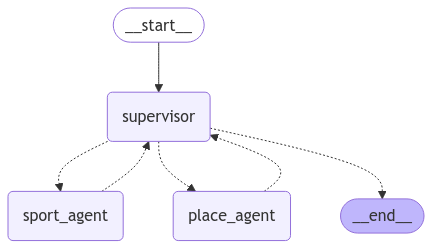

In [39]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

# Testing Agents

In [44]:
for s in graph.stream(
        {'messages': [
            ('user', "What's the age of Sean Manaea?"),
        ]}, subgraphs=True
):
    print(s)
    print("----")

print('\n==============================\n')

for s in graph.stream(
        {'messages': [
            ('user', "where I can get fresh apples?")
        ]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'sport_agent'}})
----
(('sport_agent:a60d7356-e3c5-b81d-2e0b-7368be9fac27',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tMgg8jASnfT8N51KDCetJ8Am', 'function': {'arguments': '{}', 'name': 'api_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 121, 'total_tokens': 132, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6adafee5-ef18-48fc-a2a0-2860e1552037-0', tool_calls=[{'name': 'api_tool', 'args': {}, 'id': 'call_tMgg8jASnfT8N51KDCetJ8Am', 'type': 'tool_call'}], usage_metadata={'input_tokens': 121, 'output_tokens': 11, 'total_tokens': 132, 'input_